In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
train_csv = '../data_clean/Latest Gold/market/features/spx500_features.csv'

Xraw = pd.read_csv(train_csv)

In [3]:
train_csv = '../data_clean/Latest Gold/market/features/spx500_features_enhanced.csv'

X_enhance = pd.read_csv(train_csv)

In [3]:
X = Xraw

# creating time lags and close lags
X['time'] = pd.to_datetime(X['time'])
X['time_L1'] = X['time']  - timedelta(minutes=1)
X['time_L30'] = X['time']  - timedelta(minutes=30)
X['time_L60'] = X['time']  - timedelta(minutes=60)
X = X.merge(X[['time','close']].rename(columns={'time':'time_L1'}), on='time_L1', how='left', suffixes=("","_L1"))
X = X.merge(X[['time','close']].rename(columns={'time':'time_L30'}), on='time_L30', how='left', suffixes=("","_L30"))
X = X.merge(X[['time','close']].rename(columns={'time':'time_L60'}), on='time_L60', how='left', suffixes=("","_L60"))

# creating returns
X['closereturn_L30'] = X['close']/X['close_L30'] - 1
X['closereturn_L60'] = X['close']/X['close_L60'] - 1

X = X[~X['closereturn_L30'].isna()]



C:\Users\user\AppData\Local\Temp\ipykernel_76332\333529773.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value_kpss, *_ = kpss(chunks, regression='c', nlags='auto')
C:\Users\user\AppData\Local\Temp\ipykernel_76332\333529773.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value_kpss, *_ = kpss(chunks, regression='c', nlags='auto')
C:\Users\user\AppData\Local\Temp\ipykernel_76332\333529773.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value_kpss, *_ = kpss(chunks, regression='c', nlags='auto')
C:\Users\user\AppData\Local\Temp\ipykernel_76332\333529773.py:14: Interpolat

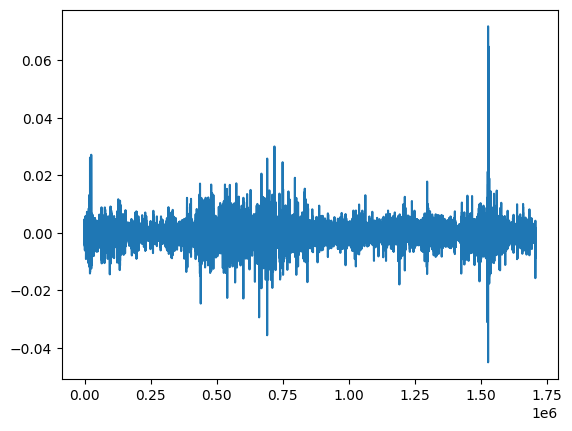

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

n_chunks=5

series_to_test = X['closereturn_L30'].dropna()
series_to_test.plot()

splits = np.array_split(series_to_test.to_numpy(dtype='float32'), n_chunks)

ret = {}
for chunk_id, chunks in enumerate(splits):
    adf_stat, p_value_adf, *_ = adfuller(chunks, autolag='AIC')
    kpss_stat, p_value_kpss, *_ = kpss(chunks, regression='c', nlags='auto')
    ret[chunk_id] = {'adf_stat': adf_stat, 'p_value_adf': p_value_adf, 'kpss_stat': kpss_stat, 'p_value_kpss':p_value_kpss,}



In [5]:
ret

{0: {'adf_stat': np.float64(-50.20582749467194),
  'p_value_adf': 0.0,
  'kpss_stat': np.float64(0.044392309583908086),
  'p_value_kpss': np.float64(0.1)},
 1: {'adf_stat': np.float64(-48.06392448623475),
  'p_value_adf': 0.0,
  'kpss_stat': np.float64(0.08402069585002203),
  'p_value_kpss': np.float64(0.1)},
 2: {'adf_stat': np.float64(-47.81332279399513),
  'p_value_adf': 0.0,
  'kpss_stat': np.float64(0.10803073053877336),
  'p_value_kpss': np.float64(0.1)},
 3: {'adf_stat': np.float64(-49.33268520655953),
  'p_value_adf': 0.0,
  'kpss_stat': np.float64(0.08715424931078479),
  'p_value_kpss': np.float64(0.1)},
 4: {'adf_stat': np.float64(-47.41675952183027),
  'p_value_adf': 0.0,
  'kpss_stat': np.float64(0.07908479641519696),
  'p_value_kpss': np.float64(0.1)}}

In [4]:
cutoff = pd.Timestamp('2023-10-12', tz='UTC')  # pick your cutoff
mask = X['time'] < cutoff
series_to_test = X.loc[mask, 'closereturn_L30']
print(len(series_to_test))
endog = series_to_test
endog.index = X.loc[mask, 'time']

cutoff2 = pd.Timestamp('2024-4-11', tz='UTC')  # pick your cutoff
mask = (cutoff <= X['time']) & (X['time'] < cutoff2)
series_to_test = X.loc[mask, 'closereturn_L30']
print(len(series_to_test))
endog_val = series_to_test
endog_val.index = X.loc[mask, 'time']

985438
147809


c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:        closereturn_L30   No. Observations:                10000
Model:               SARIMAX(1, 0, 0)   Log Likelihood               63584.991
Date:                Wed, 29 Oct 2025   AIC                        -127163.981
Time:                        19:14:24   BIC                        -127142.350
Sample:                             0   HQIC                       -127156.659
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.726e-06   4.31e-06     -0.633      0.527   -1.12e-05    5.71e-06
ar.L1          0.9650      0.002    506.274      0.000       0.961       0.969
sigma2      1.756e-07   1.07e-09    164.453      0.0

c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


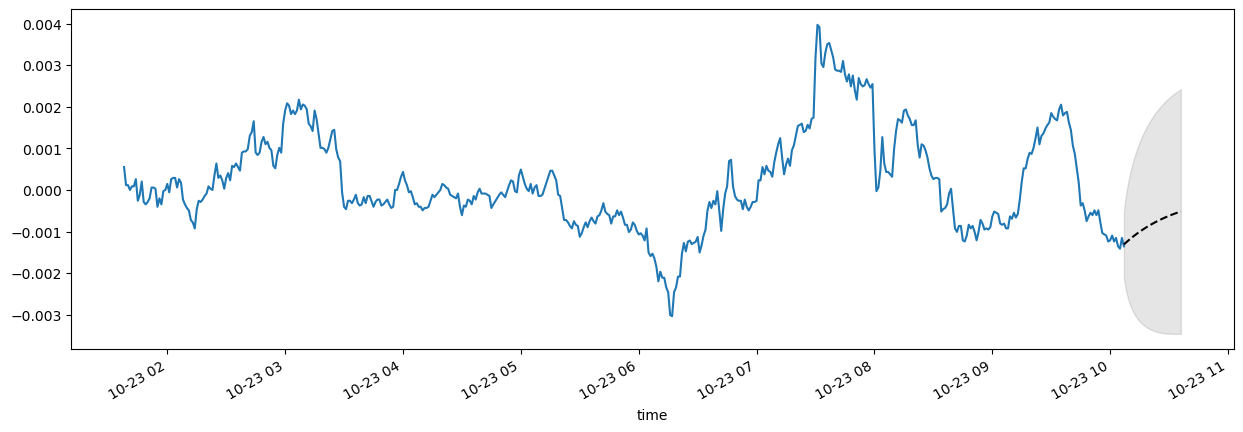

In [5]:
import statsmodels.api as sm
h=30
mod = sm.tsa.SARIMAX(endog, order=(1, 0, 0), trend="c")
res = mod.fit()

print(res.summary())

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog[-500:].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(steps=h).summary_frame()
last_timestamp = endog.index[-1]
future_index = pd.date_range(last_timestamp, periods=h, freq='min')
fcast.index = future_index

fcast["mean"].plot(ax=ax, style="k--")
ax.fill_between(
    fcast.index, fcast["mean_ci_lower"], fcast["mean_ci_upper"], color="k", alpha=0.1
)

In [ ]:
from pmdarima import auto_arima
model = auto_arima(
    endog,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    d=0,            # let the function difference as needed (ADF-based)
    seasonal=False,    # True + m>1 for seasonal data
    trace=True,
    stepwise=True,
    suppress_warnings=True,
    error_action="raise",
    with_intercept=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-9780661.978, Time=51.56 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-12429907.760, Time=71.93 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-10430615.466, Time=111.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9780640.871, Time=17.23 sec
